In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load the dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print("Dataset shape:", X.shape)
print("\nTarget distribution:")
print(y.value_counts())
print("\nTarget meanings: 0 = Malignant, 1 = Benign")

# Display basic information about the dataset
print("\nFirst few rows of features:")
print(X.head())

Dataset shape: (569, 30)

Target distribution:
target
1    357
0    212
Name: count, dtype: int64

Target meanings: 0 = Malignant, 1 = Benign

First few rows of features:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597 

In [3]:
# Check for missing values
print("Missing values in features:")
print(X.isnull().sum())

# Check for duplicates
print(f"\nNumber of duplicate rows: {X.duplicated().sum()}")

# Since this is a clean dataset, we'll proceed with feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\nFeatures scaled successfully!")

Missing values in features:
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

Number of duplicate rows: 0

Features scaled successfully!


In [4]:
# Create priority labels based on tumor characteristics
def create_priority_labels(df, target):
    """
    Create priority levels based on tumor characteristics:
    - High: Malignant tumors with large radius and high concavity
    - Medium: Malignant tumors with smaller characteristics or borderline cases
    - Low: Benign tumors
    """
    priorities = []
    
    for i in range(len(df)):
        if target.iloc[i] == 1:  # Benign
            priorities.append('low')
        else:  # Malignant
            # Use mean radius and worst concavity as indicators of severity
            radius = df.iloc[i]['mean radius']
            concavity = df.iloc[i]['worst concavity']
            
            if radius > 15 and concavity > 0.3:
                priorities.append('high')
            else:
                priorities.append('medium')
    
    return pd.Series(priorities, name='priority')

# Create priority labels
y_priority = create_priority_labels(X, y)

print("Priority distribution:")
print(y_priority.value_counts())

# Encode priority labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_priority)

# Map the encoded values back to original labels for reference
priority_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print(f"\nPriority mapping: {priority_mapping}")

Priority distribution:
priority
low       357
high      129
medium     83
Name: count, dtype: int64

Priority mapping: {0: 'high', 1: 'low', 2: 'medium'}


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTesting set class distribution:")
print(pd.Series(y_test).value_counts().sort_index())

Training set size: 455
Testing set size: 114

Training set class distribution:
0    103
1    286
2     66
Name: count, dtype: int64

Testing set class distribution:
0    26
1    71
2    17
Name: count, dtype: int64


In [6]:
# Initialize and train Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Train the model
rf_model.fit(X_train, y_train)

print("Random Forest model trained successfully!")

Random Forest model trained successfully!


In [7]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("=== MODEL EVALUATION ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

# Detailed classification report
print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== TOP 10 MOST IMPORTANT FEATURES ===")
print(feature_importance.head(10))

=== MODEL EVALUATION ===
Accuracy: 0.9474
F1-Score (weighted): 0.9426

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        high       0.96      1.00      0.98        26
         low       0.93      1.00      0.97        71
      medium       1.00      0.65      0.79        17

    accuracy                           0.95       114
   macro avg       0.97      0.88      0.91       114
weighted avg       0.95      0.95      0.94       114


=== TOP 10 MOST IMPORTANT FEATURES ===
                 feature  importance
23            worst area    0.128493
27  worst concave points    0.102924
22       worst perimeter    0.085566
20          worst radius    0.082375
2         mean perimeter    0.079184
26       worst concavity    0.073755
3              mean area    0.072838
0            mean radius    0.066978
7    mean concave points    0.057351
6         mean concavity    0.053846


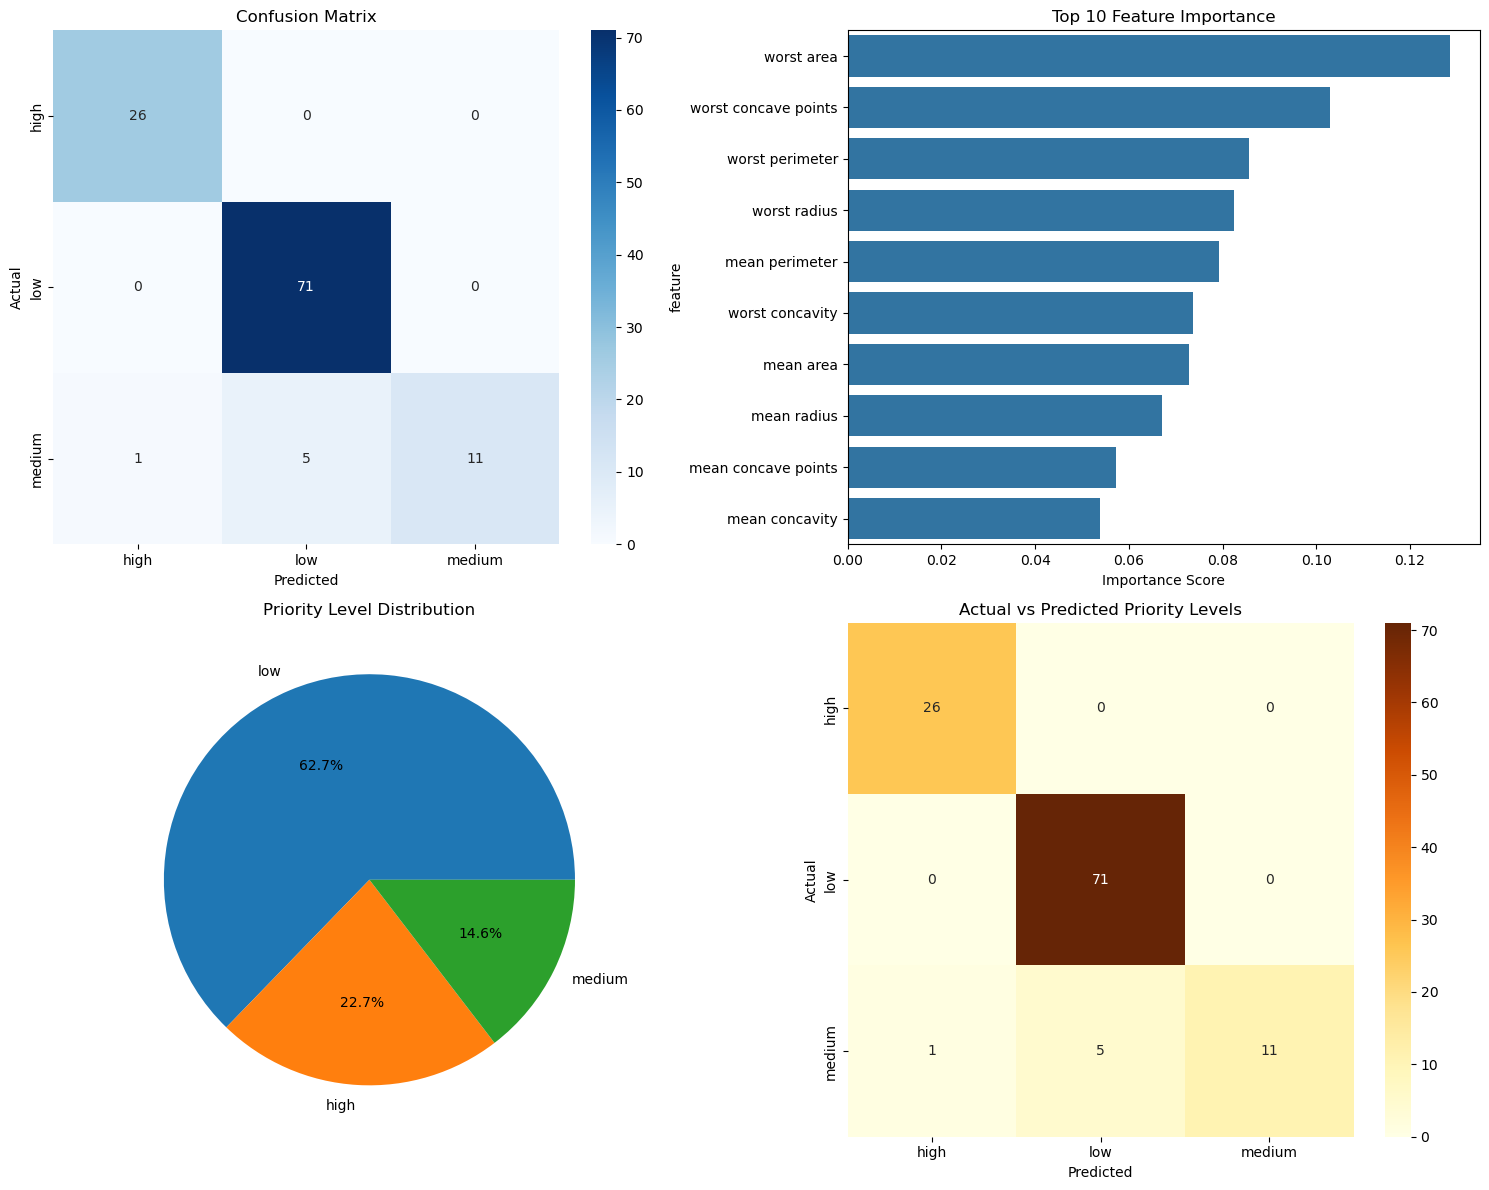

In [8]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_, ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# 2. Feature Importance
top_features = feature_importance.head(10)
sns.barplot(data=top_features, x='importance', y='feature', ax=axes[0,1])
axes[0,1].set_title('Top 10 Feature Importance')
axes[0,1].set_xlabel('Importance Score')

# 3. Class Distribution
priority_counts = pd.Series(y_priority).value_counts()
axes[1,0].pie(priority_counts.values, labels=priority_counts.index, autopct='%1.1f%%')
axes[1,0].set_title('Priority Level Distribution')

# 4. Actual vs Predicted comparison
actual_vs_pred = pd.DataFrame({
    'Actual': label_encoder.inverse_transform(y_test),
    'Predicted': label_encoder.inverse_transform(y_pred)
})
comparison = pd.crosstab(actual_vs_pred['Actual'], actual_vs_pred['Predicted'])
sns.heatmap(comparison, annot=True, fmt='d', cmap='YlOrBr', ax=axes[1,1])
axes[1,1].set_title('Actual vs Predicted Priority Levels')

plt.tight_layout()
plt.show()

In [9]:
# Define resource allocation based on predicted priorities
def allocate_resources(predictions, prediction_proba):
    """
    Allocate resources based on predicted priority levels
    """
    resource_plan = {
        'high': {
            'specialist_time': '4 hours',
            'equipment': 'Advanced imaging + biopsy',
            'follow_up': 'Weekly',
            'team_size': 'Multi-disciplinary team'
        },
        'medium': {
            'specialist_time': '2 hours',
            'equipment': 'Standard imaging',
            'follow_up': 'Bi-weekly',
            'team_size': 'Oncologist + Nurse'
        },
        'low': {
            'specialist_time': '1 hour',
            'equipment': 'Basic screening',
            'follow_up': 'Monthly',
            'team_size': 'Primary care physician'
        }
    }
    
    allocations = []
    for i, pred in enumerate(predictions):
        priority_level = label_encoder.inverse_transform([pred])[0]
        confidence = prediction_proba[i].max()
        allocation = resource_plan[priority_level].copy()
        allocation['confidence'] = f"{confidence:.2f}"
        allocations.append(allocation)
    
    return allocations

# Apply resource allocation to test set
resource_allocations = allocate_resources(y_pred, y_pred_proba)

print("=== SAMPLE RESOURCE ALLOCATIONS ===")
for i in range(min(5, len(resource_allocations))):
    print(f"\nCase {i+1}:")
    for key, value in resource_allocations[i].items():
        print(f"  {key}: {value}")

=== SAMPLE RESOURCE ALLOCATIONS ===

Case 1:
  specialist_time: 1 hour
  equipment: Basic screening
  follow_up: Monthly
  team_size: Primary care physician
  confidence: 1.00

Case 2:
  specialist_time: 4 hours
  equipment: Advanced imaging + biopsy
  follow_up: Weekly
  team_size: Multi-disciplinary team
  confidence: 0.59

Case 3:
  specialist_time: 1 hour
  equipment: Basic screening
  follow_up: Monthly
  team_size: Primary care physician
  confidence: 0.85

Case 4:
  specialist_time: 4 hours
  equipment: Advanced imaging + biopsy
  follow_up: Weekly
  team_size: Multi-disciplinary team
  confidence: 0.99

Case 5:
  specialist_time: 1 hour
  equipment: Basic screening
  follow_up: Monthly
  team_size: Primary care physician
  confidence: 0.97
